# Trend Analysis (Crop Yield)

Analyze and forecast trends in `Yield` per state and crop using `crop_yield.csv`.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')


In [3]:
# Load and clean
yield_df = pd.read_csv(os.path.join('..', 'datasets', 'crop_yield.csv'))
yield_df.columns = [c.strip().replace(' ', '_') for c in yield_df.columns]
yield_df['State'] = yield_df['State'].str.strip().str.title()
yield_df['Crop'] = yield_df['Crop'].str.strip().str.title()

In [4]:
# Explore top crops
top_crops = yield_df['Crop'].value_counts().head(5).index.tolist()
subset = yield_df[yield_df['Crop'].isin(top_crops)].copy()

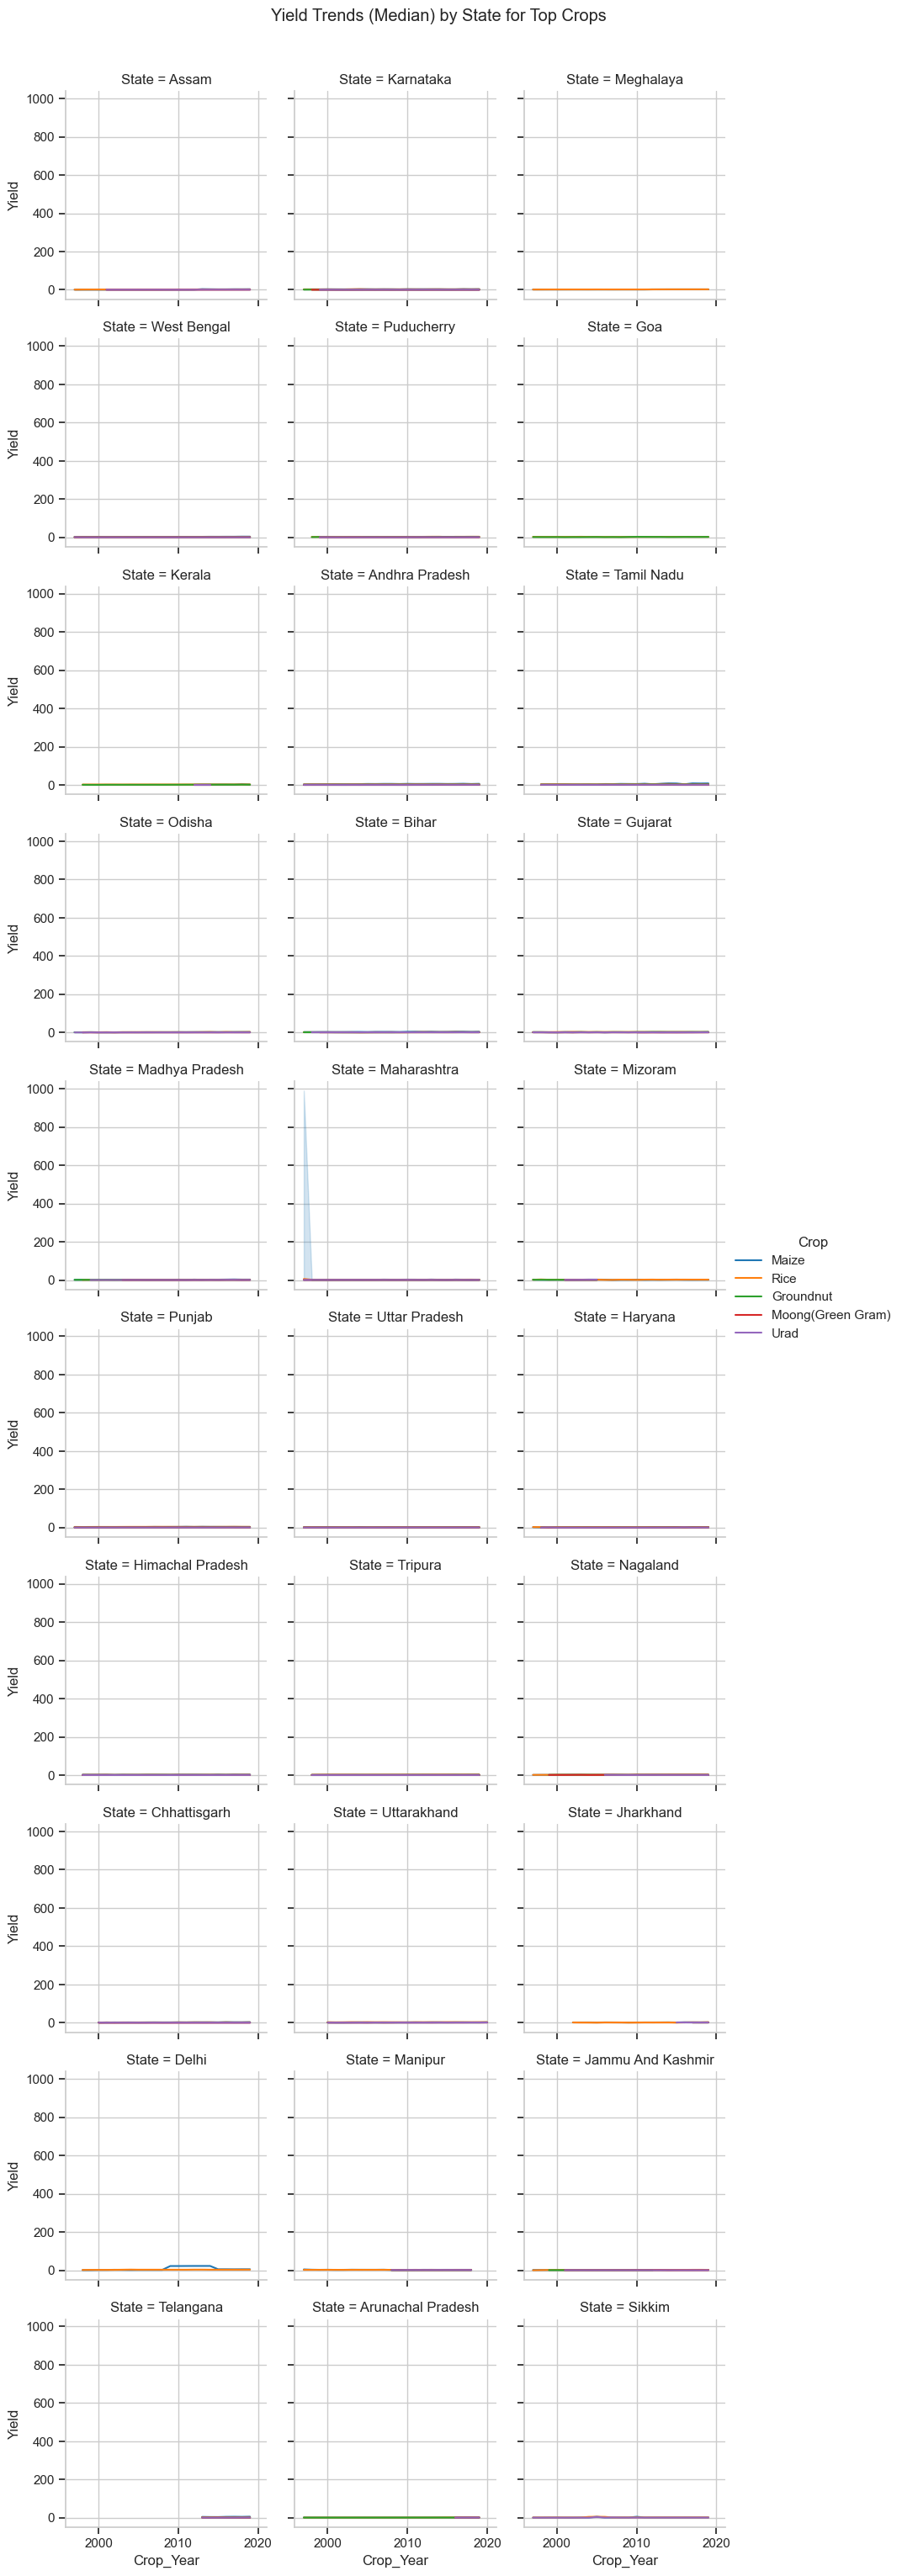

In [5]:
# Plot trends
g = sns.relplot(data=subset, x='Crop_Year', y='Yield', hue='Crop', col='State',
               kind='line', col_wrap=3, height=3, estimator='median')
plt.suptitle('Yield Trends (Median) by State for Top Crops', y=1.02)
plt.show()

In [6]:
# Per-(State,Crop) ridge regression with temporal split
forecasts = []
for (state, crop), grp in subset.groupby(['State', 'Crop']):
    grp = grp.sort_values('Crop_Year')
    if grp['Crop_Year'].nunique() < 5:
        continue
    Xg = grp[['Crop_Year']].values
    yg = grp['Yield'].values
    split = int(0.8 * len(grp))
    X_tr, X_te = Xg[:split], Xg[split:]
    y_tr, y_te = yg[:split], yg[split:]

    mdl = Ridge(alpha=1.0)
    mdl.fit(X_tr, y_tr)
    y_pred = mdl.predict(X_te)
    mae, r2 = mean_absolute_error(y_te, y_pred), r2_score(y_te, y_pred)

    last_year = int(grp['Crop_Year'].max())
    future_years = np.arange(last_year + 1, last_year + 6)
    y_future = mdl.predict(future_years.reshape(-1, 1))

    forecasts.append({'State': state, 'Crop': crop, 'MAE': mae, 'R2': r2,
                      'future_years': future_years, 'future_yield': y_future})

c:\Users\SOHAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


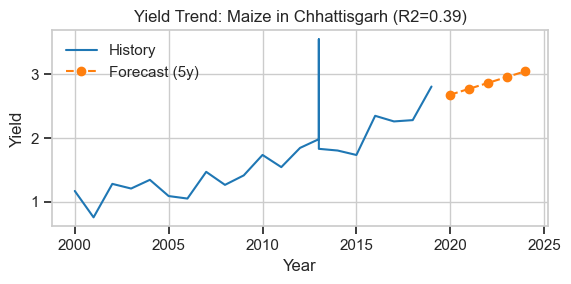

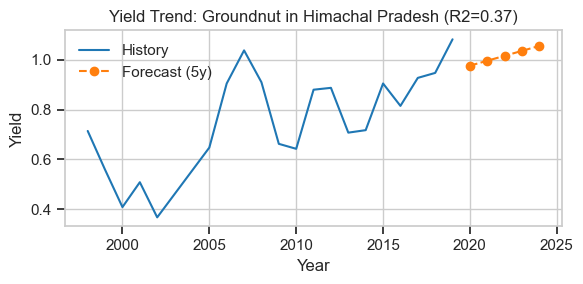

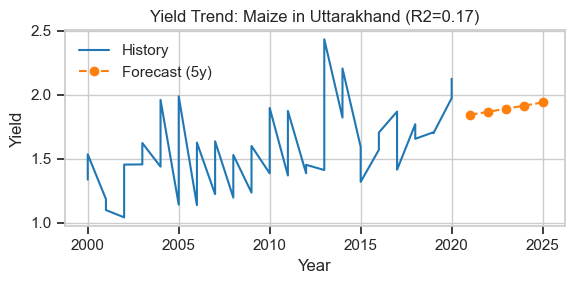

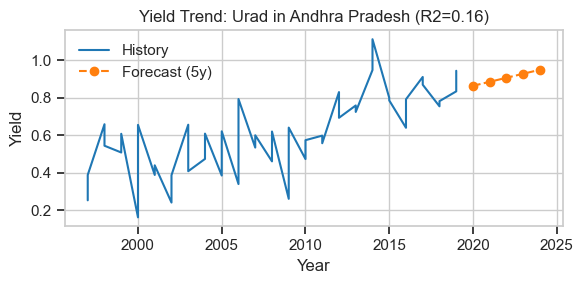

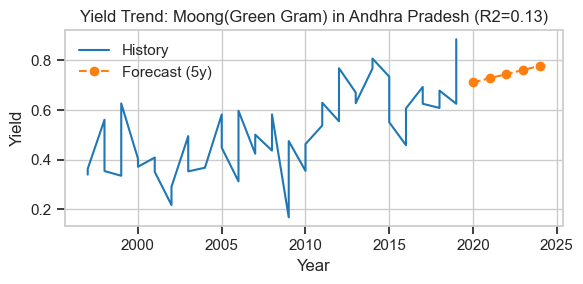

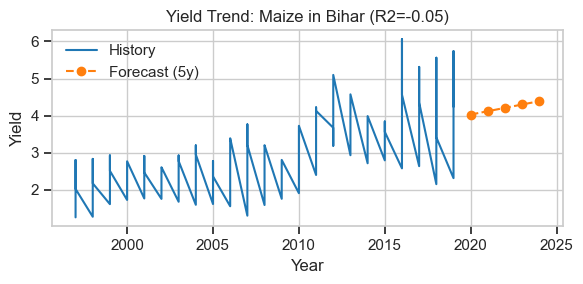

In [7]:
best_groups = sorted(forecasts, key=lambda d: d['R2'], reverse=True)[:6]
for fg in best_groups:
    state, crop = fg['State'], fg['Crop']
    grp = subset[(subset['State']==state) & (subset['Crop']==crop)].sort_values('Crop_Year')
    plt.figure(figsize=(6,3))
    plt.plot(grp['Crop_Year'], grp['Yield'], label='History')
    plt.plot(fg['future_years'], fg['future_yield'], 'o--', label='Forecast (5y)')
    plt.title(f'Yield Trend: {crop} in {state} (R2={fg["R2"]:.2f})')
    plt.xlabel('Year')
    plt.ylabel('Yield')
    plt.legend()
    plt.tight_layout()
    plt.show()